# TD de machine Learning : Catégorisation musicale

**Elective** : Machine Learning   
**Professeur** : Théophile Ravillion   
**Date** : Vendredi 23 Avril 2021

## Contexte 
Vous travaillez chez Deezer, département Data Science, félicitations.
D'habiles ingénieurs musicologues ont mis au point un jeu de données contenant des informations sur des morceaux de musique. 
Avec quelques transformées de Fourier et autres joyeusetés propres à leur art, ils ont mis au point deux jeux de données contenant de nombreux indicateurs décrivant un morceau de musique.
Ils comptent sur vous pour mettre au point un algorithme capable d'identifier le genre musical d'un morceau sur la base des différents indicateurs qu'ils ont mis au point.
Vous vous apprétiez à leur demander des informations concernant ces variables mais vous constatez qu'ils sont partis en séminaire d'entreprise et que vous vous retrouvez tout seul avec un jeu d'entrainement étiqueté, un jeu de test et un post-it goguenard de votre chef qui vous demande de faire des prédictions précises sur le jeu de test d'ici 16h.

## Votre défi :
Modéliser le problème, construire un modèle et faire une prédiction de la catégorie à laquelle appartient chaque élément du fichier test.csv à l'aide d'un modèle aussi simple et performant que possible.


## Livrable
Un projet github contenant un notebook + un fichier prédictions.csv contenant les prédictions faites sur le jeu de test

En header le nom des colonnes (music_id et prediction) et pour chacun des morceaux la catégorie prédite.
Merci d'utiliser la virgule comme séparateur 

Bonne chance !

# Feuille de route

Comment procéder ? 
Pour réaliser cet exercice, il vous faudra :

## Récuperer les données 

In [74]:
import pandas as pd

url_train = "https://raw.githubusercontent.com/RTheophile/td_ml_ynov/main/data/train.csv"
url_test = "https://raw.githubusercontent.com/RTheophile/td_ml_ynov/main/data/test.csv"

df_train = pd.read_csv(url_train, sep=',', decimal='.' )
df_test = pd.read_csv(url_test, sep=',', decimal='.' )


## Analyser les données  
Identifier la distribution de chaque variable  
Données manquantes    
Données aberrantes   
Données corrélées entre elles  

### Boite à outils :   
**Décrire le contenu d'un dataframe pandas**   
`df.info()`   
`df.describe()`   

Gallerie Seaborn : https://seaborn.pydata.org/examples/index.html#   
Histograme : https://seaborn.pydata.org/generated/seaborn.histplot.html   
PairPlot : https://seaborn.pydata.org/generated/seaborn.pairplot.html   
Corrélogramme : https://seaborn.pydata.org/generated/seaborn.heatmap.html   

**Imputation des valeurs manquantes :**   
KNNImputer : https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html  
`df['chroma_0_mean'] = df['chroma_0_mean'].fillna(df['chroma_0_mean'].mean())`  
`df['chroma_0_mean'] = df['chroma_0_mean'].fillna(df['chroma_0_mean'].median())`  
`df['chroma_0_mean'] = df['chroma_0_mean'].fillna(df['chroma_0_mean'].mode())`  

**Quelques fonctions pandas utiles :**  
**Supprimer la ligne** i du dataframe df :   
`df.drop(i, axis=0, inplace=True)`
  
**Supprimer la colonne** c du dataframe df :   
`df.drop(i, axis=1, inplace=True)`
  
**Appliquer la fonction f** sur la colonne c du dataframe df :   
`df[c] = df[c].apply(lambda x : f(x))`

**Selectionner**  les 5 premiers éléments d'un dataframe df :   
`df.head(5)`

**Selectionner**  les 5 derniers éléments d'un dataframe df :   
`df.tail(5)`

**Selectionner**  les éléments d'un dataframe qui satisfont une condition :   
ex : selectionner toutes les lignes dont le prix est supérieur à 100 :  
`df[df['prix'] > 100]`

In [75]:
from sklearn.preprocessing import RobustScaler
import seaborn as sns
import matplotlib.pyplot as plt
#sns.set_theme(style="whitegrid")
import numpy as np
from sklearn.ensemble import IsolationForest

# selection des données choisies
y_train = df_train.category
x_train = df_train.drop(['music_id','category'], axis=1)

#y_test = df_test.category
x_test = df_test.drop(['music_id'], axis=1)

In [76]:
low = .01
high = .99
quant_x_train = x_train.quantile([low, high])
print(quant_x_train)

      chroma_0_mean  chroma_0_std  chroma_10_mean  chroma_10_std  \
0.01      68.040730     149.24075       83.854005     145.631409   
0.99    1575.673862    2905.63333     1180.163311    3177.124736   

      chroma_11_mean  chroma_11_std  chroma_1_mean  chroma_1_std  \
0.01       77.765060     147.186099      63.892709    151.386116   
0.99     1430.011858    2194.680186    1280.827540   2445.392202   

      chroma_2_mean  chroma_2_std  ...  mfcc_9_mean  mfcc_9_std  onset_rate  \
0.01      76.783065    145.147651  ...     -0.58266    0.421674    0.557086   
0.99    1628.426111   3399.686855  ...      0.68679    1.124202   10.820101   

      spectral_centroid_mean  spectral_decrease_mean  spectral_flux_mean  \
0.01                4.383937               -0.606771            0.426512   
0.99               72.098191                0.040442            5.337702   

      spectral_rolloff_mean  spectral_spread_mean    zcr_mean     zcr_std  
0.01              25.574561             86.7624

In [77]:
quant_x_test = x_test.quantile([low, high])
print(quant_x_test)

      chroma_0_mean  chroma_0_std  chroma_10_mean  chroma_10_std  \
0.01      67.166157    174.340061       71.752604     213.086806   
0.99    1419.793418   2925.076843     1393.418823    1987.688357   

      chroma_11_mean  chroma_11_std  chroma_1_mean  chroma_1_std  \
0.01       48.673218     112.077002      66.227910    152.005895   
0.99     1372.612059    1652.640652    1352.824714   1778.884612   

      chroma_2_mean  chroma_2_std  ...  mfcc_9_mean  mfcc_9_std  onset_rate  \
0.01      71.050747    137.828181  ...    -0.452122    0.436510    0.396490   
0.99    1289.793221   1469.885360  ...     0.614832    1.340871   10.577345   

      spectral_centroid_mean  spectral_decrease_mean  spectral_flux_mean  \
0.01                5.466366               -0.566346            0.382212   
0.99               61.436525                0.047397            4.748525   

      spectral_rolloff_mean  spectral_spread_mean    zcr_mean     zcr_std  
0.01             281.750000            136.6912

In [78]:
# Affichage NaN x_train
x_train = x_train.apply(lambda x: x[(x>quant_x_train.loc[low,x.name]) & 
                                    (x < quant_x_train.loc[high,x.name])], axis=0)

for col_name in x_train.columns:
    print(x_train.isna()[col_name].value_counts())
    print ('---')
    
#x_train.shape

False    309
True      11
Name: chroma_0_mean, dtype: int64
---
False    309
True      11
Name: chroma_0_std, dtype: int64
---
False    309
True      11
Name: chroma_10_mean, dtype: int64
---
False    309
True      11
Name: chroma_10_std, dtype: int64
---
False    310
True      10
Name: chroma_11_mean, dtype: int64
---
False    312
True       8
Name: chroma_11_std, dtype: int64
---
False    310
True      10
Name: chroma_1_mean, dtype: int64
---
False    311
True       9
Name: chroma_1_std, dtype: int64
---
False    308
True      12
Name: chroma_2_mean, dtype: int64
---
False    309
True      11
Name: chroma_2_std, dtype: int64
---
False    310
True      10
Name: chroma_3_mean, dtype: int64
---
False    305
True      15
Name: chroma_3_std, dtype: int64
---
False    308
True      12
Name: chroma_4_mean, dtype: int64
---
False    308
True      12
Name: chroma_4_std, dtype: int64
---
False    311
True       9
Name: chroma_5_mean, dtype: int64
---
False    310
True      10
Name: chroma_5_st

In [79]:
# Affichage NaN x_test
x_test = x_test.apply(lambda x: x[(x>quant_x_test.loc[low,x.name]) & 
                                    (x < quant_x_test.loc[high,x.name])], axis=0)
for col_name in x_test.columns:
    print(x_test.isna()[col_name].value_counts())
    print ('---')

False    76
True      4
Name: chroma_0_mean, dtype: int64
---
False    78
True      2
Name: chroma_0_std, dtype: int64
---
False    77
True      3
Name: chroma_10_mean, dtype: int64
---
False    77
True      3
Name: chroma_10_std, dtype: int64
---
False    76
True      4
Name: chroma_11_mean, dtype: int64
---
False    77
True      3
Name: chroma_11_std, dtype: int64
---
False    78
True      2
Name: chroma_1_mean, dtype: int64
---
False    77
True      3
Name: chroma_1_std, dtype: int64
---
False    76
True      4
Name: chroma_2_mean, dtype: int64
---
False    76
True      4
Name: chroma_2_std, dtype: int64
---
False    78
True      2
Name: chroma_3_mean, dtype: int64
---
False    77
True      3
Name: chroma_3_std, dtype: int64
---
False    78
True      2
Name: chroma_4_mean, dtype: int64
---
False    77
True      3
Name: chroma_4_std, dtype: int64
---
False    75
True      5
Name: chroma_5_mean, dtype: int64
---
False    76
True      4
Name: chroma_5_std, dtype: int64
---
False    78


In [80]:
# retrait des données NaN x_train: On remplace par la moyenne étant donné 
#qu'il n'y a que 3 Nan par colonne
for col in x_train.columns :
    x_train[col] = x_train[col].fillna(x_train[col].mean())

#x_train.shape

In [81]:
# retrait des données NaN x_test: On remplace par la moyenne étant donné 
#qu'il n'y a que 3 Nan par colonne
for col in x_test.columns :
    x_test[col] = x_test[col].fillna(x_test[col].mean())

In [82]:
# Affichage du nombre de NaN x_train
for col_name in x_train.columns:
    print(x_train.isna()[col_name].value_counts())
    print ('---')
    
#x_train.shape

False    320
Name: chroma_0_mean, dtype: int64
---
False    320
Name: chroma_0_std, dtype: int64
---
False    320
Name: chroma_10_mean, dtype: int64
---
False    320
Name: chroma_10_std, dtype: int64
---
False    320
Name: chroma_11_mean, dtype: int64
---
False    320
Name: chroma_11_std, dtype: int64
---
False    320
Name: chroma_1_mean, dtype: int64
---
False    320
Name: chroma_1_std, dtype: int64
---
False    320
Name: chroma_2_mean, dtype: int64
---
False    320
Name: chroma_2_std, dtype: int64
---
False    320
Name: chroma_3_mean, dtype: int64
---
False    320
Name: chroma_3_std, dtype: int64
---
False    320
Name: chroma_4_mean, dtype: int64
---
False    320
Name: chroma_4_std, dtype: int64
---
False    320
Name: chroma_5_mean, dtype: int64
---
False    320
Name: chroma_5_std, dtype: int64
---
False    320
Name: chroma_6_mean, dtype: int64
---
False    320
Name: chroma_6_std, dtype: int64
---
False    320
Name: chroma_7_mean, dtype: int64
---
False    320
Name: chroma_7_std, dty

In [83]:
# Affichage du nombre de NaN x_test
for col_name in x_test.columns:
    print(x_test.isna()[col_name].value_counts())
    print ('---')

False    80
Name: chroma_0_mean, dtype: int64
---
False    80
Name: chroma_0_std, dtype: int64
---
False    80
Name: chroma_10_mean, dtype: int64
---
False    80
Name: chroma_10_std, dtype: int64
---
False    80
Name: chroma_11_mean, dtype: int64
---
False    80
Name: chroma_11_std, dtype: int64
---
False    80
Name: chroma_1_mean, dtype: int64
---
False    80
Name: chroma_1_std, dtype: int64
---
False    80
Name: chroma_2_mean, dtype: int64
---
False    80
Name: chroma_2_std, dtype: int64
---
False    80
Name: chroma_3_mean, dtype: int64
---
False    80
Name: chroma_3_std, dtype: int64
---
False    80
Name: chroma_4_mean, dtype: int64
---
False    80
Name: chroma_4_std, dtype: int64
---
False    80
Name: chroma_5_mean, dtype: int64
---
False    80
Name: chroma_5_std, dtype: int64
---
False    80
Name: chroma_6_mean, dtype: int64
---
False    80
Name: chroma_6_std, dtype: int64
---
False    80
Name: chroma_7_mean, dtype: int64
---
False    80
Name: chroma_7_std, dtype: int64
---
False 

In [84]:
# Affichage des colonnes qui influent le plus le résultat
numeric_features = df_train.select_dtypes(include=[np.number])
corr = numeric_features.corr()
#corr
print (corr['category'].sort_values(ascending=False)[:10], '\n')
print (corr['category'].sort_values(ascending=False)[-10:])

category                1.000000
onset_rate              0.363652
mfcc_4_mean             0.359016
mfcc_2_std              0.273260
mfcc_13_mean            0.269931
zcr_std                 0.256540
spectral_spread_mean    0.254121
mfcc_8_mean             0.234996
mfcc_11_mean            0.234832
chroma_3_std            0.234073
Name: category, dtype: float64 

chroma_11_std   -0.091350
mfcc_4_std      -0.100506
mfcc_11_std     -0.114193
mfcc_5_std      -0.142124
chroma_max      -0.203903
mfcc_10_std     -0.252480
mfcc_6_std      -0.297109
mfcc_9_std      -0.339786
mfcc_7_std      -0.379257
mfcc_8_std      -0.389740
Name: category, dtype: float64


## Normaliser les données
Choisir une méthode de normalisation, comparer les résultats obtenus avec différentes méthodes 

### Boite à outils

K-NN : https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html   
Robust Scaler : https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html   
StandardScaler : 
https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler         
MinMaxScaler : 
https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler      

(320, 12)

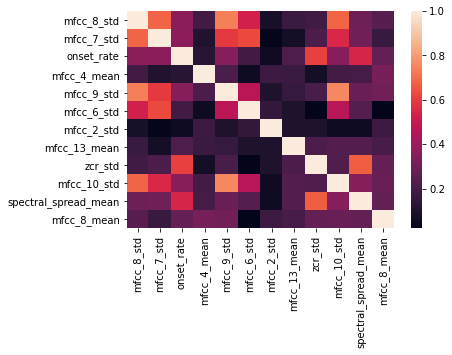

In [85]:
# Données corrélées entres elles
# Selection des données jugées pertinantes
x_train = x_train[['mfcc_8_std', 
                    'mfcc_7_std', 
                    'onset_rate', 
                    'mfcc_4_mean', 
                    'mfcc_9_std', 
                    'mfcc_6_std', 
                    'mfcc_2_std',
                    'mfcc_13_mean',
                    'zcr_std',
                    'mfcc_10_std',
                    'spectral_spread_mean',
                    'mfcc_8_mean']]
#x_train.shape
matrice_correlation = x_train.corr().abs()
sns.heatmap(matrice_correlation)
x_train.shape

In [86]:
from sklearn.preprocessing import StandardScaler
# Application d'un RobustScaler : Normalisation des données
transformer_train_scaler = StandardScaler().fit(x_train)
transformer_test_scaler = StandardScaler().fit(x_test)

transformer_train_transform = transformer_train_scaler.transform(x_train)
transformer_test_transform = transformer_test_scaler.transform(x_test)
#transformer_train_transform
print(np.std(transformer_train_transform,axis=0,ddof=0))


[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [87]:
print(np.std(transformer_test_transform,axis=0,ddof=0))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [88]:
#pca correct => slide 59 cours 4 => valeur du coude (elbow method)
#essais differentes valeurs, selon le nombre d'axe que l'on prend / garde
from sklearn.decomposition import PCA

acp = PCA(svd_solver='full')#, n_components = 12)
acp.fit(x_train)
coord = acp.fit_transform(transformer_train_transform)
#print(acp.n_components)
#print(acp.explained_variance_)

n = x_train.shape[0]
eigval = (n-1)/n*acp.explained_variance_
print(eigval)

[4.35179437 1.80710201 1.34499395 0.8939601  0.83777839 0.68484557
 0.54096118 0.45234799 0.34495464 0.27262784 0.25488846 0.21374551]


In [89]:
print(acp.explained_variance_ratio_)

[0.36264953 0.15059183 0.11208283 0.07449667 0.06981487 0.05707046
 0.0450801  0.03769567 0.02874622 0.02271899 0.02124071 0.01781213]


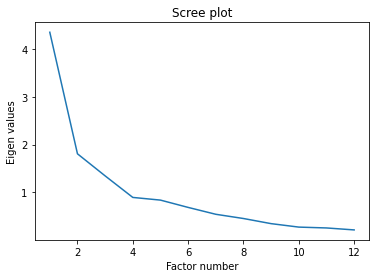

In [90]:
# Variance en fonction des axes
p = x_train.shape[1]
plt.plot(np.arange(1,p+1),eigval)
plt.title("Scree plot")
plt.ylabel("Eigen values")
plt.xlabel("Factor number")
plt.show()


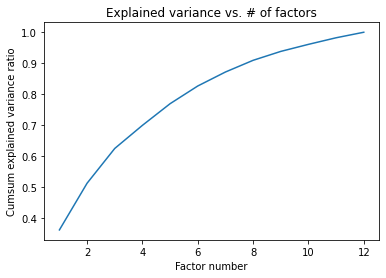

In [91]:
# 
p = x_train.shape[1]
plt.plot(np.arange(1,p+1),np.cumsum(acp.explained_variance_ratio_))
plt.title("Explained variance vs. # of factors")
plt.ylabel("Cumsum explained variance ratio")
plt.xlabel("Factor number")
plt.show()

## Etudier l’opportunité d’une réduction de dimension
- Tester les perfs obtenus pour différentes valeurs
- Visualiser la variance expliquée par chaque axe
- Justifier le nombre d’axes retenus

### Boite à outils  
Analyse en composante principale : https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html   

In [92]:
from sklearn.model_selection import train_test_split

x = x_train#.values
y = df_train['category'].values

y

array([1, 3, 3, 1, 1, 0, 3, 1, 2, 1, 0, 3, 2, 3, 0, 3, 2, 1, 0, 0, 2, 2,
       1, 1, 1, 3, 0, 2, 0, 0, 2, 0, 0, 3, 0, 1, 2, 2, 0, 2, 1, 1, 1, 2,
       1, 1, 1, 1, 0, 2, 2, 3, 3, 3, 3, 1, 2, 3, 0, 0, 1, 3, 3, 0, 3, 2,
       1, 0, 2, 1, 1, 2, 0, 0, 0, 2, 1, 2, 2, 1, 2, 0, 1, 0, 2, 3, 3, 3,
       0, 1, 0, 0, 3, 1, 0, 3, 3, 1, 0, 3, 2, 0, 2, 2, 2, 3, 0, 2, 2, 2,
       3, 1, 2, 1, 0, 1, 3, 2, 3, 3, 0, 2, 2, 3, 3, 0, 0, 2, 1, 2, 0, 3,
       2, 2, 2, 3, 0, 3, 3, 0, 1, 3, 1, 0, 1, 1, 3, 2, 3, 3, 1, 0, 0, 3,
       2, 2, 1, 2, 2, 2, 0, 2, 1, 0, 0, 3, 0, 3, 0, 3, 3, 1, 1, 1, 2, 2,
       3, 3, 0, 3, 2, 3, 0, 1, 3, 2, 2, 3, 0, 1, 3, 2, 3, 2, 3, 3, 1, 3,
       1, 0, 1, 0, 1, 3, 2, 2, 0, 1, 2, 0, 0, 3, 3, 2, 3, 1, 3, 0, 3, 0,
       2, 1, 0, 1, 2, 1, 3, 1, 0, 3, 0, 1, 1, 2, 3, 0, 3, 0, 1, 2, 1, 3,
       3, 1, 1, 0, 0, 2, 2, 1, 0, 1, 3, 2, 2, 2, 0, 2, 3, 2, 3, 0, 1, 1,
       1, 0, 1, 1, 0, 0, 2, 0, 2, 1, 2, 2, 2, 2, 0, 3, 2, 2, 3, 3, 1, 3,
       2, 0, 0, 0, 0, 3, 1, 2, 0, 3, 3, 0, 3, 1, 0,

In [93]:
x_TRAIN, x_TEST, y_TRAIN, y_TEST = train_test_split(x,
                                                    y,
                                                    test_size = 0.33,
                                                    random_state = 42)

In [94]:
x_TRAIN

,mfcc_8_std,mfcc_7_std,onset_rate,mfcc_4_mean,mfcc_9_std,mfcc_6_std,mfcc_2_std,mfcc_13_mean,zcr_std,mfcc_10_std,spectral_spread_mean,mfcc_8_mean
184,0.479624,0.466996,3.531764,0.210835,0.628279,0.492636,1.295528,-0.101096,88.186177,0.736414,194.118483,0.022127
113,0.613184,0.504625,1.932474,0.364530,0.486606,0.575527,0.950324,-0.126522,104.338107,0.559534,1588.218721,0.094855
19,0.916078,0.706908,1.032874,-0.542149,0.925028,0.667703,1.230345,-0.524779,76.683830,0.824559,175.829657,0.099215
182,0.643594,0.611151,4.264771,-1.146401,0.664712,0.501517,0.688123,-0.111276,94.841288,0.622983,1835.221281,-0.377129
92,0.491559,0.492808,4.882263,0.444707,0.462123,0.505464,0.883371,0.371008,122.905022,0.457048,2265.102890,0.565675
...,...,...,...,...,...,...,...,...,...,...,...,...
188,0.625531,0.705153,0.899600,-1.563447,0.625774,0.522751,1.029028,0.194587,78.624760,0.559898,901.994168,-0.290985
71,0.413711,0.440975,4.866637,0.810609,0.422931,0.513459,0.848175,0.009183,66.998691,0.414466,1364.132016,-0.501767
106,0.700622,0.738819,4.031542,-0.506012,0.788376,0.726102,0.828096,-0.313818,145.978240,0.695242,2743.526931,0.187112
270,0.495519,0.582559,7.596624,0.089056,0.575819,0.534961,0.930550,0.193094,226.804836,0.468020,7040.842229,0.504162


In [95]:
y_TRAIN

array([3, 1, 0, 0, 3, 1, 2, 0, 0, 3, 3, 1, 0, 2, 1, 1, 3, 2, 2, 2, 0, 2,
       0, 0, 0, 2, 0, 0, 3, 0, 1, 0, 1, 2, 1, 2, 1, 0, 2, 0, 1, 0, 2, 2,
       1, 2, 3, 1, 0, 2, 0, 2, 0, 3, 1, 0, 1, 0, 2, 2, 2, 0, 0, 0, 0, 2,
       1, 3, 2, 2, 0, 3, 2, 1, 3, 3, 2, 2, 1, 0, 3, 1, 1, 3, 0, 3, 3, 1,
       0, 0, 1, 1, 0, 0, 0, 1, 3, 1, 1, 0, 2, 3, 2, 3, 2, 2, 1, 0, 2, 1,
       3, 1, 1, 3, 3, 3, 0, 1, 2, 2, 2, 1, 2, 0, 1, 1, 0, 3, 3, 3, 1, 3,
       3, 1, 1, 2, 1, 3, 3, 1, 0, 1, 1, 1, 3, 0, 0, 3, 3, 1, 0, 3, 1, 3,
       1, 1, 1, 0, 2, 2, 0, 3, 2, 3, 3, 3, 2, 2, 2, 0, 1, 0, 3, 1, 3, 3,
       0, 1, 0, 3, 2, 1, 1, 3, 2, 2, 1, 1, 3, 3, 0, 0, 0, 3, 2, 0, 2, 2,
       2, 2, 3, 0, 0, 3, 3, 3, 2, 2, 2, 0, 2, 0, 2, 2], dtype=int64)

In [96]:
x_TEST

,mfcc_8_std,mfcc_7_std,onset_rate,mfcc_4_mean,mfcc_9_std,mfcc_6_std,mfcc_2_std,mfcc_13_mean,zcr_std,mfcc_10_std,spectral_spread_mean,mfcc_8_mean
167,0.705153,0.644089,7.841021,-0.107630,0.884043,0.595347,1.305990,-0.103673,136.718015,0.671012,433.771799,0.187437
230,1.121844,0.622180,8.363678,-1.741429,0.831069,0.617742,0.978705,-0.078280,183.253939,0.932804,1520.400248,0.201577
25,0.476282,0.437387,9.792894,-0.173990,0.464308,0.423446,0.927660,0.037542,94.938017,0.619900,747.650988,-0.056864
63,1.092268,0.804059,1.099511,-0.178801,0.710534,0.482530,1.179848,0.096039,41.438765,0.813788,1835.221281,-0.457897
9,0.590379,0.749337,5.264327,-0.527708,0.601287,0.660254,0.882304,0.066722,68.767890,0.515122,358.190976,-0.083488
...,...,...,...,...,...,...,...,...,...,...,...,...
108,0.472188,0.489004,6.530431,0.960526,0.586914,0.461752,1.394076,0.112195,148.208232,0.476166,5809.791869,0.298296
269,1.076870,0.817099,3.031986,-1.276160,0.970222,0.859446,0.841829,-0.160184,111.516300,1.107269,1991.690485,0.009538
66,0.599395,0.487359,5.397601,0.688694,0.423942,0.479389,0.744812,0.013090,98.885628,0.454217,2310.820853,0.076043
197,0.651716,0.587120,3.698356,-1.133314,0.645780,0.562448,1.297221,-0.075332,88.052322,0.643124,389.044042,-0.351902


In [97]:
y_TEST

array([3, 0, 3, 0, 1, 3, 2, 0, 1, 2, 0, 1, 1, 1, 1, 3, 1, 2, 1, 2, 3, 3,
       1, 0, 1, 2, 0, 3, 0, 1, 2, 0, 0, 2, 0, 2, 3, 1, 0, 2, 1, 2, 3, 2,
       1, 1, 3, 3, 3, 3, 3, 0, 0, 1, 1, 2, 0, 1, 1, 0, 0, 3, 2, 3, 2, 1,
       3, 2, 1, 3, 0, 2, 2, 2, 2, 0, 1, 3, 3, 3, 1, 3, 0, 3, 3, 1, 2, 1,
       2, 0, 2, 3, 3, 2, 0, 1, 2, 0, 2, 3, 3, 2, 0, 1, 3, 0], dtype=int64)

## Créer un échantillon non biaisé de validation
A moins que vous n'utilisiez la k-fold validation (stratifiée ?)

### Boite à outil :   
`from sklearn.model_selection import train_test_split`  

In [99]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline


svc = make_pipeline(StandardScaler(), SVC(gamma='auto'))
svc.fit(x_TRAIN, y_TRAIN)

print(svc.predict(x_TEST))

[3 0 3 0 1 3 0 0 1 2 0 3 1 2 1 0 3 2 1 3 3 0 2 0 1 2 1 3 0 2 2 0 0 2 0 2 3
 2 0 2 1 2 3 2 2 1 2 2 3 0 2 0 0 1 1 2 1 0 2 0 0 2 2 3 1 1 3 2 1 3 3 2 3 2
 1 3 1 3 1 3 1 0 0 0 3 1 2 1 2 0 2 2 3 2 0 1 2 0 1 1 3 2 0 2 0 3]


In [101]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor()
rfr.fit(x_TRAIN,y_TRAIN)
rfr_pred = rfr.predict(x_TEST)

from sklearn import metrics

metrics.r2_score(y_TEST,rfr_pred)

0.3817896113175193

In [102]:
#from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression

rl = LogisticRegression(random_state=0).fit(x_TRAIN,y_TRAIN)
rl.predict(x_TEST)

C:\Users\julien\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


array([1, 1, 2, 2, 1, 1, 2, 0, 1, 1, 0, 3, 2, 2, 0, 0, 3, 2, 0, 2, 1, 1,
       2, 0, 3, 2, 1, 0, 0, 2, 2, 0, 0, 2, 1, 1, 1, 2, 2, 2, 1, 2, 3, 2,
       1, 0, 2, 2, 2, 0, 1, 0, 0, 1, 1, 2, 1, 0, 2, 3, 0, 2, 2, 3, 2, 1,
       1, 2, 2, 1, 1, 1, 2, 2, 2, 3, 3, 0, 0, 3, 1, 0, 0, 0, 2, 1, 2, 3,
       1, 0, 2, 1, 1, 2, 0, 1, 2, 0, 2, 1, 3, 2, 0, 2, 0, 3], dtype=int64)

## Entrainer différents algorithmes de classification

`model = ...`   
`model.fit(X_train, y_train)`

### Boite à outils  
SVM : https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html   
Random Forest : https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier   
Regression logistique : https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html   

## Comparer la performance de différents algorithmes
Faire des prédictions et evaluer leur justesse de ces prédictions à l'aide de différents indicateurs :
- Matrice de confusion
- Accuracy
- F-Score

### Boite à outils  
Un rapport de performance clé en main : https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html   

Liste des différents indicateurs : https://scikit-learn.org/stable/modules/model_evaluation.html

Faire une prédiction avec un model sklearn entrainé :
`y_pred_1 = model_1.predict(X_val, y_val)`   





## Optimiser les hyper-paramètres de l’algorithme retenu
Tester différents hyper-paramètres pour tirer au mieux partit de l'algorithme retenu

### Boite à outils  
GridSearchCV :  https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html



## Prédire des valeurs pour le jeu de test 
Créer un fichier au format .csv contenant  vos prédictions.
En header le nom des colonnes (music_id et prediction) et pour chacun des morceaux la catégorie prédite.

Vérifier que votre notebook fonctionne avant de le rendre 

### Boite à outils  
exporter un dataFrame pandas au format csv :
`df_test.to_csv('data/test.csv' , sep=',', decimal='.')`